<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLabel Classification And Regression


In the last chapter, we learned some practical tips for training models, like choosing the right learning rates and number of epochs which were really important for good results. Now, this chapter dives into two new types of computer vision problems: multi-label classification (predicting multiple labels for an image or none at all) and regression (predicting numbers instead of categories). Along the way, we'll explore output activations, targets, and loss functions in more depth.

## MultiLabel Classification

*MultiLabel Classification* refers to the problem of identifying the objects in images that may not contain exactly one type of object.

There may be more than one type of object or there may be none.

In previous bear classifier we built, it had no ability to predict "not bear at all". So, this time we are trying to fix that.

First, let's see what a mutilabel dataset looks like. But before that lets set up the notebook.

In [1]:
### Setting up the notebook
##@ Notebook initialization
%reload_ext autoreload
%autoreload 2
%matplotlib inline

##@ Installing dependencies
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

##@ Importing the necessary libraries
from fastbook import *
from fastai.callback.fp16 import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


### Getting Data

We will get the PASCAL datset which has more than one kind of classified object per image.

In [2]:
##@ Getting the PASCAL dataset
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv')]

<details>
<summary><b>More about this dataset:</b></summary>
This dataset is a bit different from the ones we've worked with before. Instead of being organized by filenames or folders, it comes with a CSV file that tells us which labels to use for each image.
</details>


In [3]:
##@ inspecting the dataset
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
header = """
===============================================================
                Pandas and DataFrames Subsection in Book
===============================================================
"""
print(header)

# Accessing rows and columns using .iloc
print("------- Using .iloc: -------")
print(f"Returning the 1st column of the dataframe:\n\n{df.iloc[:, 0]} \n")  # 1st column (labels)
print(f"Returning the 1st row of the dataframe:\n\n{df.iloc[0, :]} \n")    # 1st row (details of item1)

# Grabbing a column by name (without using iloc)
print(f"Grabbing the column 'labels' directly from the dataframe:\n\n{df['labels']}\n\n")

# Calculations in the dataframe
print("----- Calculations in the DataFrame itself ------ \n")
print("Creating a new dataframe for this one:\n")
df1 = pd.DataFrame({
    'Items Sold': [5, 2, 5, 4, 9],
    'Rates': [100, 50, 60, 400, 1000]
})
print(f"The new dataframe before the calculation:\n\n{df1}\n")
df1['Income'] = df1['Items Sold'] * df1['Rates']  # Calculating income as Items Sold * Rates

print(f"The new dataframe after the calculation:\n\n{df1}\n")


                Pandas and DataFrames Subsection in Book

------- Using .iloc: -------
Returning the 1st column of the dataframe:

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object 

Returning the 1st row of the dataframe:

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object 

Grabbing the column 'labels' directly from the dataframe:

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object


----- Calculations in the DataFrame itself ------ 

Creating a new dataframe for this one:

The new dataframe before the calc

### Constriucting a DataBlock

#### Key Concepts

Before diving into the DataBlock construction, it is important to understand the two main classes used in PyTorch and FastAI to represent datasets and batches:

- **Dataset**: A collection that returns a tuple of the independent variable (input) and the dependent variable (target) for a single item.
- **DataLoader**: An iterator that provides a stream of mini-batches. Each mini-batch consists of a batch of inputs and a batch of targets.

FastAI adds two additional layers on top of these:

- **Datasets**: An iterator that contains both the training and validation datasets.
- **DataLoaders**: An object that contains a training DataLoader and a validation DataLoader.

A DataLoader is built on top of a Dataset to add functionalities like batching, shuffling, and parallel data loading.

#### Step-by-Step Construction of a DataBlock

##### **1. Starting Simple: DataBlock With No Parameters**

---
We begin my creating an empty ```DataBlock``` object with no parameters. This serves as the foundation for building the DataBlock step by step.

In [5]:
dblock = DataBlock()

Next, we create a ```Datasets``` object from this ```DataBlock```. The only required argument is the data source—in this case, a **DataFrame**.

In [6]:
dsets = dblock.datasets(df)

This creates a training and validation dataset, which can be accessed as:

In [7]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

By default, the ```DataBlock``` assumes there are two items: the input (independent variable) and the target (dependent variable). This will simply return a row of the DataFrame.

##### **2. Specifying the Input Target with ```get_x``` and ```get_y```**

---

To handle the DataFrame more effectively, we specify which columns correspond to the input and target variables using ```get_x``` and ```get_y``` functions.

In [8]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [9]:
#@ Alternatively, we can define the functions more explicitly:
def get_x(r):
  return r['fname']

def get_y(r):
  return r['labels']

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

Although using **lambda functions** is convenient, they are not compatible with serialization. For saving models after training, it's better to use the more verbose function definitions.

##### **3. Adjusting the ```get_x``` and ```get_y``` Functions:**

---

Moreover, we need convert the independent variable to the complete path so that we can open it as an image, and dependent variable will need to be split on the space character, so that it becomes a list.

In [10]:
#@ Diffrent returns this time

def get_x(r):
  return path/'train'/r['fname']

def get_y(r):
  return r['labels'].split(' ')

dblock = DataBlock(get_x= get_x, get_y= get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

##### **4. Defining The Block Types**

---

We now need to specify the block types. Block types define how the data is processed into the correct format. For images, we use ```ImageBlock``` for the input and ```MultiCategoryBlock``` for the output, since we are doing multi-label classification.

In [11]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x, get_y= get_y)
dsets= dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

> Note: ```TensorMultiCategory``` in output represents the multi-label format where a 1 indicates that a particular category is present for that item (similar to one-hot encoding).

##### **5. One-Hot Encoding**

---

In multi-label classification, we use one-hot encoding to represent labels.

In [12]:
##@ We can get the actual labels using torch.where function

idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

<details>
  <summary>
    <b>
      Explaining the code snippet:
    </b>
  </summary>
<ul>
  <li>
  <Code>dsets.train[0][1]</code>: Here <code>dests.train[0]</code> part gets the first training example and the <code>[1]</code> part gets the label or target associated with that example.
  </li>
  <li>
  <code>torch.where(...)[0]</code> the <code>[0]</code> here selects the first element of the tuple returned by <code>torch.where</code>, which contains the indices of <code>True</code> elements.
  </li>
</ul>
</details>

##### **6. Handling the Validation Set**

---

By default, the DataBlock uses a random split to create training and validation datasets. However, we can define our own custom split by using a ```splitter``` function. This function takes the entire ```DataFrame``` and returns two lists: one for the training set and one for the validation set.

In [13]:
#@ Defining the custom splitter function

def splitter(df):
  train = df.index[~df['is_valid']].tolist()  #The ~ is used to indicate is False ie., is not valid
  valid = df.index[df['is_valid']].tolist()
  return train, valid

## Passing the function created to the DataBlock

dblock= DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter= splitter,
                  get_x= get_x, get_y= get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

##### **7. Creating DataLoaders**

---

After confirming that the individual items look correct, we now need to ensure that every item has the same size, as PyTorch requires tensors of the same shape. We can use transforms like ```RandomResizedCrop``` to resize the images.

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

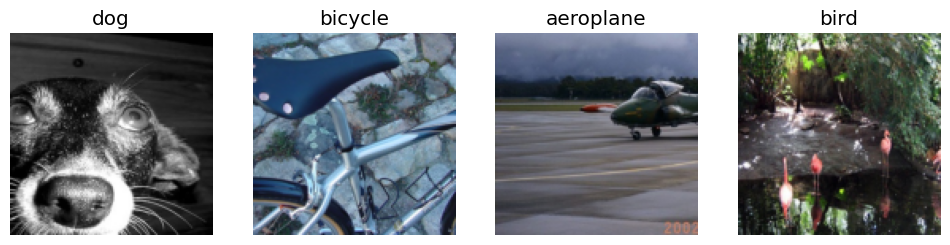

In [15]:
##@ Showing the batches
dls.show_batch(nrows=1, ncols=4)

##### **8. Debugging and Validation**

---

We got the correct labels here. But, if anything goes wrong when creating our ```DataLoaders``` from our ```DataBlock```, we can use the ```summary()``` method to check the contents of the ```DataBlock``` and its transfromations

In [28]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

### Binary Cross Entropy

In [29]:
#@ Creating the Learner

learn = vision_learner(dls, resnet18)

In [30]:
##@ Creating minibatch
x, y= to_cpu(dls.train.one_batch())
activ = learn.model(x)
activ.shape

torch.Size([64, 20])

--- Batch Size: 64 and  we need to calculate the probability of each of 20 categories. ---

In [31]:
##@ Checking  one of the entries
activ[0]

TensorImage([-1.5989, -1.1440, -0.2083,  0.0572, -0.0460, -2.6841,  2.9333,  0.4771, -1.2518, -0.5205,  0.7620, -0.0070,  0.5642,  0.0912, -0.6342,  2.7291,  2.5803, -1.5317, -0.3073, -0.4592],
            grad_fn=<AliasBackward0>)

The tensors are everywhere. So scaling them in between 0 to 1.

In [32]:
##@ Using Sigmoid Function
def binary_cross_entropy (inputs, targets):
  inputs= inputs.sigmoid()                  ## Sigmoid activation
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

<details>
  <summary>
    <b>
      The reason behind using - 've" sign before <code>torch.where().log()</code> :
    </b>
  </summary>
  Since the logarithm of a number between 0 and 1 is negative, and  we want the loss to be positive.

  Also, cross entropy loss is also known as negative log-likelihood.

  So, we negate the log values to get the positive loss values.
</details>

<details>
  <summary>
    <b>
      Why not Softmax or NLLLoss?
    </b>
  </summary>
  <ul>
  <li>
    <b>Softmax</b> requires all predictions to sum to 1, which is not ideal for multi-label classification, where we may have multiple labels for a single image.
  </li>
  <li>
    <b>NLLLoss</b> works with single-label classification, where the target is a single class, but we need a method that handles multiple labels independently.
  </li>
  </ul>
</details>

In [36]:
##@ Using PyTorch Builtin BCE Loss Function

loss_func = nn.BCEWithLogitsLoss()
activ_tensor = activ.as_subclass(torch.Tensor)
y_tensor = y.as_subclass(torch.Tensor)
loss = loss_func(activ_tensor, y_tensor)
loss

tensor(1.0072, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

#### Metric For Multi-Label Classification:

For multi-label classification, we can't use the standard accuracy metric because we might have multiple labels for each input. Here's a modified version of the accuracy function that works for multi-label problems:

In [37]:
def accuracy_multi(inp, targ, thresh= 0.5, sigmoid= True):
  if sigmoid:           #Apply sigmoid if required
    inp = inp.sigmoid()

  return ((inp > thresh)== targ.bool()).float().mean()

<details>
  <summary>
    <b>
      How it works:
    </b>
  </summary>
  <ul>
  <li>
  <b>Thresholding:</b> After applying the sigmoid to the activations, we need to decide which class activations are considered 1 (present) and which are 0 (absent). This is done by applying a threshold (default 0.5).
  </li>
  <li>
  <b>Comparing:</b> We compare the thresholded predictions to the target labels, then compute the accuracy by averaging the matches across the batch.
  </li>
  </ul>
</details>

#### Customizing the Threshold

We can modify the default threshold for the accuracy function using ```partial``` from Python’s ```functools``` to create a version of ```accuracy_multi``` with a custom threshold.

In [38]:
##@ creating next learner with threshold

from functools import partial

#@ Setting custom threshold of 0.2
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [39]:
##@ Training the model:
"Once the loss function and metrics are set up, we can train the model as:"

learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.953242,0.696120,0.232390,00:28
1,0.830225,0.547921,0.276892,00:30
2,0.605609,0.193355,0.824980,00:44
3,0.357401,0.115357,0.951912,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.128690,0.104219,0.953625,00:26
1,0.115204,0.094805,0.957630,00:28
2,0.097295,0.095080,0.958944,00:30


In [40]:
##@ Validating the model : On low threshold
learn.metrics = partial(accuracy_multi, thresh= 0.1)
learn.validate()

(#2) [0.09507967531681061,0.9408565163612366]

In [41]:
##@ Validating the model : On high threshold
learn.metrics = partial(accuracy_multi, thresh= 0.99)
learn.validate()

(#2) [0.09507967531681061,0.9425099492073059]

In [42]:
##@ Finding the best threshold value
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh= 0.9, sigmoid= False)

tensor(0.9575)

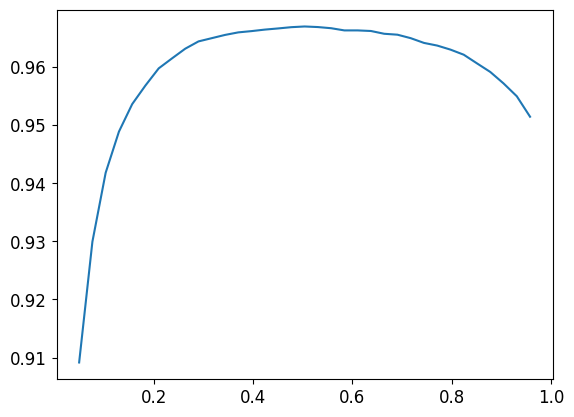

In [44]:
###@ Now using this approach to find the best threshold level

xs = torch.linspace(0.05, 0.9575, 35)
accs= [accuracy_multi(preds, targs, thresh = i, sigmoid= False) for i in xs]
plt.plot(xs, accs)